# Neural Network

This notebook implements, tunes, and using cross validated metrics evaluates a neural network regression model in Pytorch.

### 1. Imports and Seed Setting
We begin by importing the necessary libraries to build the neural network in Pytorch, preprocess the data, and conduct cross-validation. We also set a random seed in Pytorch and Numpy for reproducibility.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_predict

# Set seeds for reproducibility
torch.manual_seed(123)
np.random.seed(123)
random.seed(123)

### 2. Load Data

We load the training dataset from GitHub. We do not touch the test dataset here, as it will be used later for final evaluation.

In [2]:
# Load in training data from Github
X_train = pd.read_csv("https://raw.githubusercontent.com/hzheni/ML4021-final-project/refs/heads/main/Data/X_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/hzheni/ML4021-final-project/refs/heads/main/Data/y_train.csv")
y_train = y_train.values.ravel() # Flatten to 1D array

### 3. Build Pytorch Neural Network Model

We define a neural network model using Pytorch's `nn.Module`. The model consists of 2 layers with ReLU activation functions to add non-linearity. We also define the forward pass of the network to return a single output value for regression.

In [3]:
# Neural Network Model

# Define a model through nn.Module
class MyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        l1 = nn.Linear(input_dim, hidden_dim)
        a1 = nn.ReLU() # Activation function to add some non-linearity
        l2 = nn.Linear(hidden_dim, hidden_dim) # 2 hidden layers to learn more complex patterns
        a2 = nn.ReLU()
        output = nn.Linear(hidden_dim, 1) # Output layer for regression
        l = [l1, a1, l2, a2, output] # store layers in a list
        self.module_list = nn.ModuleList(l)

    def forward(self, X):
        for layer in self.module_list:
            X = layer(X)
        return X

### 4. Scikit-learn Wrapper for Pytorch Model

To integrate the Pytorch model with Scikit-learn's cross-validation utilities, we create a wrapper class `MyNNRegressor` that inherits from `BaseEstimator` and `RegressorMixin`. This class includes methods for fitting the model, making predictions, and setting hyperparameters.

In [4]:
# Define a sklearn-compatible wrapper for the PyTorch model to allow for pipelines and hyperparameter tuning
# Have BaseEstimator so that we can use get_params and set_params for hyperparameter tuning
# Have RegressorMixin so that sklearn knows this is a regressor and has score methods
class MyNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, hidden_dim=64, lr=0.001, batch_size=32, epochs=50, seed=123):
        self.input_dim = input_dim # Store each parameter as an attribute
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        
    def fit(self, X, y):
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

        # Create the model
        self.model_ = MyModel(self.input_dim, self.hidden_dim)
        self.criterion_ = nn.MSELoss() # Use Mean Squared Error loss for regression
        self.optimizer_ = torch.optim.Adam(self.model_.parameters(), lr=self.lr) # Adam optimizer 

        # Convert data to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1) # Reshape for compatibility
        # Create DataLoader for batching
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self.model_.train() # Set model to training mode
        self.loss_history = [] # Keep track of loss values to plot a loss curve later

        # Training loop, iterate over epochs and batches
        for epoch in range(self.epochs):
            for batch_X, batch_y in dataloader:
                self.optimizer_.zero_grad() # Zero the gradients
                preds = self.model_(batch_X) # Forward pass to get predictions
                loss = self.criterion_(preds, batch_y) # Compute loss
                loss.backward() # Backpropagation to compute gradients
                self.optimizer_.step() # Update model parameters
            self.loss_history.append(loss.item()) # Store loss value for this epoch
        return self

    def predict(self, X):
        self.model_.eval() # Set model to evaluation mode
        X_tensor = torch.tensor(X, dtype=torch.float32) # Convert input to tensor
        preds = self.model_(X_tensor).detach().numpy() # Get predictions and convert to numpy array
        return preds.ravel() # Flatten to 1D array

### 5. Build Pipeline, Hyperparameter Tuning, and Cross-Validation

We create a Scikit-learn pipeline that first standardizes the features using `StandardScaler` and then applies our Pytorch neural network regressor. This ensures that the input features are properly scaled before being fed into the neural network.

We define a grid of hyperparameters to tune, including the number of hidden dimensions, learning rate, batch size, and epochs. We use `GridSearchCV` to perform 5-fold cross-validation and find the best combination of hyperparameters based on mean squared error.


In [5]:
# Create a pipeline with data scaling and the neural network regressor
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('nn_regressor', MyNNRegressor(input_dim=X_train.shape[1]))])

# Hyperparameter tuning using GridSearchCV
param_grid = {'nn_regressor__hidden_dim': [32, 64, 128],
              'nn_regressor__lr': [0.0001, 0.001, 0.01],
              'nn_regressor__batch_size': [16, 32, 64],
              'nn_regressor__epochs': [25, 50, 100]}

# Set up cross-validation and grid search
kf = KFold(n_splits=5, shuffle=True, random_state=123) # 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1) 
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
# Print the best hyperparameters and corresponding performance
print("Best estimator:", best_model)
print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV MSE:", -grid_search.best_score_)
print("Best CV RMSE:", np.sqrt(-grid_search.best_score_))
# Print r-squared for best model using cross_val_predict
y_cv_pred = cross_val_predict(best_model, X_train, y_train, cv=kf, n_jobs=-1) # We use cross_val_predict to get predictions for each fold using the best model
r2 = r2_score(y_train, y_cv_pred)
print("Best CV R²:", r2)

# Evaluate the best model on training data, note that this is just for reference/will be optimistic since the model has seen this data before since we used cross-validation for model selection above
y_pred = best_model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Training MSE: {mse:.4f}")
print(f"Training RMSE: {np.sqrt(mse):.4f}")
print(f"Training R²: {r2:.4f}")

Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('nn_regressor',
                 MyNNRegressor(batch_size=16, hidden_dim=128, input_dim=46,
                               lr=0.0001))])
Best Hyperparameters: {'nn_regressor__batch_size': 16, 'nn_regressor__epochs': 50, 'nn_regressor__hidden_dim': 128, 'nn_regressor__lr': 0.0001}
Best CV MSE: 8.813377032881254
Best CV RMSE: 2.968733237069517
Best CV R²: -0.14453538621338424
Best Hyperparameters: {'nn_regressor__batch_size': 16, 'nn_regressor__epochs': 50, 'nn_regressor__hidden_dim': 128, 'nn_regressor__lr': 0.0001}
Training MSE: 5.8595
Training RMSE: 2.4207
Training R²: 0.2393


### 6. Figures

**Training Loss Curve**

The training loss curve shows how the model's loss decreased over time, indicating learning progress. A steady decrease suggests effective learning, and the plateau towards the end indicates convergence.

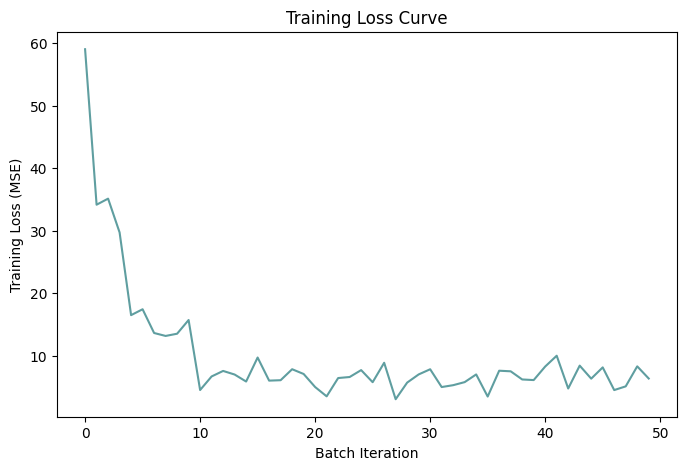

In [6]:
losses = best_model.named_steps['nn_regressor'].loss_history
plt.figure(figsize=(8,5))
plt.plot(losses, color='cadetblue')
plt.xlabel("Batch Iteration")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss Curve")
plt.show()

**Grid Search CV Hyperparameters**

The graph shows the relationship between different hyperparameter combinations and their corresponding mean squared errors. Specifically, MSE changes for different combinations of learning rate and hidden dimensions. This visualization helps in understanding how different hyperparameter settings impact model performance.

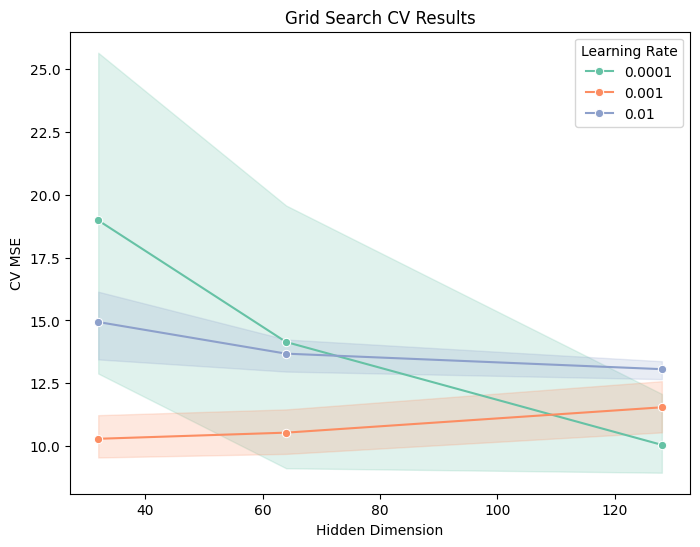

In [7]:
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8,6))
sns.lineplot(data=results, x='param_nn_regressor__hidden_dim', y=-results['mean_test_score'], hue='param_nn_regressor__lr', marker='o', palette='Set2')
plt.xlabel("Hidden Dimension")
plt.ylabel("CV MSE")
plt.legend(title="Learning Rate")
plt.title("Grid Search CV Results")
plt.show()

**Actual vs Predicted Plot**

The dotted red line represents perfect predictions. We can see that the points follow a somewhat positive sloping trend, indicating that the model is capturing some of the underlying patterns in the data. But, there is still significant spread in predicted values for each actual value, indicating room for improvement. We can also see that the model tends to overpredict lower actual values and underpredict higher actual values.

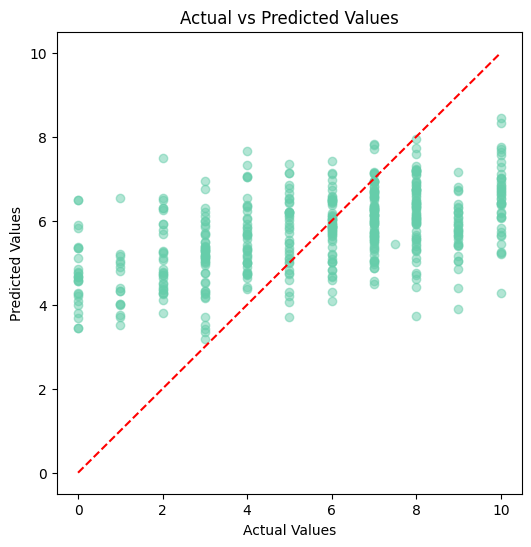

In [8]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred, alpha=0.5, color='mediumaquamarine')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--') # Diagonal line

**Residuals Histogram**

The histogram of residuals appears to be roughly normally distributed around zero, which is a good sign. This suggests that the model's errors are random and not biased in one direction. However, there are some outliers in the tails, indicating that there are a few instances where the model's predictions were significantly off.

Text(0.5, 1.0, 'Histogram of Residuals')

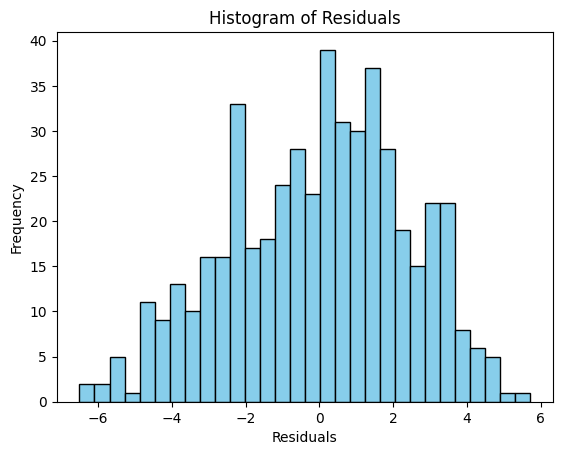

In [9]:
residuals = y_train - y_pred # Calculate residuals, the differences between actual and predicted values
plt.hist(residuals, bins=30, edgecolor='k', color='skyblue')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

**Grid Search Results Table**
The table shows the results of the grid search for hyperparameter tuning, specifically the top 10 combinations of hyperparameters based on mean test scores.

In [10]:
# Extract results from grid search
cv_results = pd.DataFrame(grid_search.cv_results_)

# Keep relevant columns
results_table = cv_results[['param_nn_regressor__hidden_dim',
                            'param_nn_regressor__lr',
                            'param_nn_regressor__batch_size',
                            'param_nn_regressor__epochs',
                            'mean_test_score']].copy()  # mean_test_score is neg MSE

# Convert neg MSE to positive MSE
results_table['mean_test_MSE'] = -results_table['mean_test_score']
results_table['mean_test_RMSE'] = results_table['mean_test_MSE'] ** 0.5
results_table = results_table.drop(columns=['mean_test_score'])
# Sort by mean_test_RMSE
results_table = results_table.sort_values(by='mean_test_RMSE').reset_index(drop=True)
results_table.head(n=10)

,param_nn_regressor__hidden_dim,param_nn_regressor__lr,param_nn_regressor__batch_size,param_nn_regressor__epochs,mean_test_MSE,mean_test_RMSE
0,128,0.0001,16,50,8.813377,2.968733
1,128,0.0001,64,100,8.820650,2.969958
2,64,0.0001,16,50,8.836240,2.972581
3,128,0.0001,32,50,8.839060,2.973056
4,64,0.0001,32,100,8.850741,2.975019
5,128,0.0001,32,100,8.897018,2.982787
6,64,0.0001,16,100,8.934000,2.988980
7,64,0.0010,64,25,8.937587,2.989580
8,128,0.0001,16,25,8.939842,2.989957
9,64,0.0001,64,100,9.079229,3.013176
